In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, desc, col, count, isnan, year, to_date
import os

# --- 1. Set up Spark session ---
spark = SparkSession.builder.appName("combined_metadata").getOrCreate()

# --- 2. Load dataset ---
csv_path = "combined_metadata.csv"

# Load with Pandas
pdf = pd.read_csv(csv_path)

# Load with Spark
sdf = spark.read.option("quote", "\"").option("escape", "\"").csv(csv_path, header=True, inferSchema=True)

# --- 3. QUESTIONS ---

print("Question 1: Average duration (seconds) of all videos")

# Pandas
avg_duration_pd = pdf["duration_seconds"].mean()
print("Pandas ->", (avg_duration_pd), "seconds")

# Spark
avg_duration_sp = sdf.select(avg("duration_seconds")).first()[0]
print("Spark ->", (avg_duration_sp), "seconds")

print("Question 2: Uploader that appears most frequently")

# Pandas
most_freq_uploader_pd = pdf["uploader"].value_counts().idxmax()
print("Pandas ->", most_freq_uploader_pd)

# Spark
most_freq_uploader_sp = sdf.groupBy("uploader").count()#.orderBy(desc("count")).first()[0]
print("Spark ->", most_freq_uploader_sp)

print("Question 3: Five videos with the highest average number of likes")

# Pandas
top5_likes_pd = pdf.sort_values(by="like_count", ascending=False)[["title", "like_count"]].head(5)
print("Pandas ->")
print(top5_likes_pd)

# Spark
top5_likes_sp = sdf.select("title", "like_count").orderBy(desc("like_count")).limit(5)
print("Spark ->")
top5_likes_sp.show(truncate=False)


print("Question 4: Average number of likes per upload year")

# Pandas
pdf["upload_year"] = pd.to_datetime(pdf["upload_date"], format = "%Y%m%d", errors="coerce").dt.year
avg_likes_by_year_pd = pdf.groupby("upload_year")["like_count"].mean().dropna()
print("Pandas ->")
print(avg_likes_by_year_pd)

#Spark
try:
    df_sp = sdf.withColumn("upload_date_parsed", to_date(col("upload_date"), "yyyyMMdd"))
    df_sp = df_sp.withColumn("upload_year", year("upload_date_parsed"))

    # Group by year and calculate average likes (filter out null years)
    avg_likes_by_year_sp = df_sp.filter(col("upload_year").isNotNull()) \
        .groupBy("upload_year") \
        .agg(avg("like_count").alias("avg_likes")) \
        .orderBy("upload_year")

    print("Spark ->")
    avg_likes_by_year_sp.show(truncate=False)

except Exception as e:
    print(f"Spark date parsing failed: {e}")
    print("Using alternative approach with existing year_uploaded column:")

    # Alternative: Use existing year_uploaded column
    avg_likes_by_year_simple = sdf.groupBy("year_uploaded") \
        .agg(avg("like_count").alias("avg_likes")) \
        .orderBy("year_uploaded")

    print("Spark (alternative) ->")
    avg_likes_by_year_simple.show(truncate=False)

print("Question 5: Number of videos missing artist information")

# Pandas
missing_artist_pd = pdf["artist"].isna().sum()
print("Pandas ->", missing_artist_pd, "videos")

# Spark
missing_artist_sp = sdf.filter(col("artist").isNull() | isnan("artist")).count()
print("Spark ->", missing_artist_sp, "videos")

: 

Question 1: How many tags does each video have? Visualize the distribution using a histogram.


<Figure size 800x500 with 0 Axes>

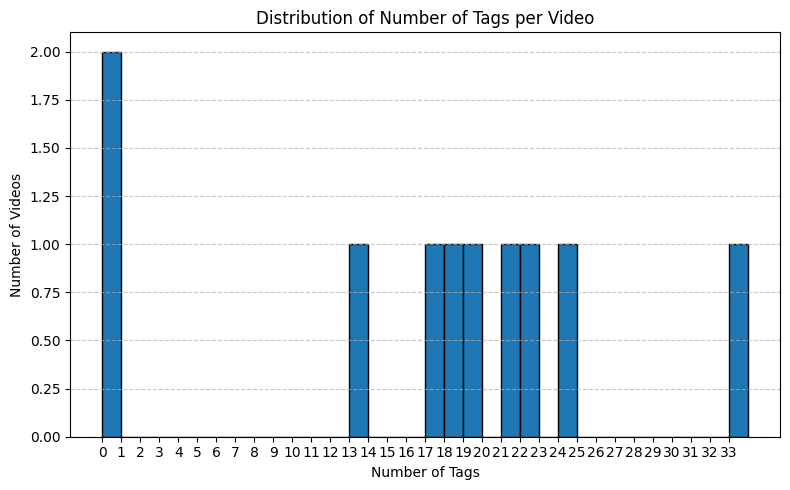

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/combined_metadata.csv')

# Show the first few rows to confirm
#print(df.head())

#print(df['tag_count'])

print("Question 1: How many tags does each video have? Visualize the distribution using a histogram.")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Customize the plot
plt.figure(figsize=(8, 5))
plt.hist(df['tag_count'], bins=range(df['tag_count'].max() + 2), edgecolor='black')
plt.title('Distribution of Number of Tags per Video')
plt.xlabel('Number of Tags')
plt.ylabel('Number of Videos')
plt.xticks(range(df['tag_count'].max() + 1))  # cleaner x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Question 1: How many tags does each video have? Visualize the distribution using a histogram.


<Figure size 800x500 with 0 Axes>

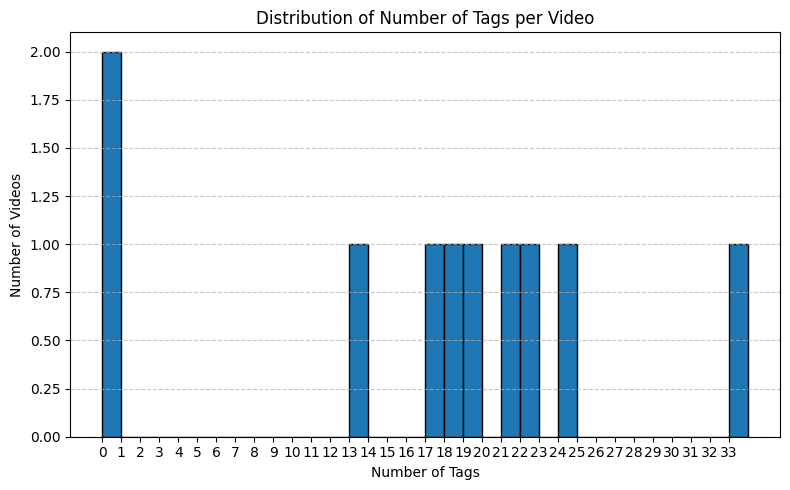

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/combined_metadata.csv')

# Show the first few rows to confirm
#print(df.head())

#print(df['tag_count'])

print("Question 1: How many tags does each video have? Visualize the distribution using a histogram.")

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Customize the plot
plt.figure(figsize=(8, 5))
plt.hist(df['tag_count'], bins=range(df['tag_count'].max() + 2), edgecolor='black')
plt.title('Distribution of Number of Tags per Video')
plt.xlabel('Number of Tags')
plt.ylabel('Number of Videos')
plt.xticks(range(df['tag_count'].max() + 1))  # cleaner x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
print("Question 2: What is the total number of views per uploader? Rank the results in descending order.")

from pyspark.sql.functions import col, sum

views_per_uploader = df_sp.withColumn("view_count", col("view_count").cast("int")) \
    .groupBy("uploader") \
    .agg(sum("view_count").alias("total_views")) \
    .orderBy("total_views", ascending=False)

views_per_uploader.show(truncate=False)


Question 2: What is the total number of views per uploader? Rank the results in descending order.
+-------------------------+-----------+
|uploader                 |total_views|
+-------------------------+-----------+
|On Ice Perspectives      |4891643    |
|Movieclips               |3531991    |
|How To Renovate A Chateau|1636747    |
|Boho Beautiful Yoga      |1319581    |
|Infinite Codes           |1088236    |
|Victor Costa Productions |756785     |
|Brian Lagerstrom         |346718     |
|trailersencasa           |220614     |
|Dave Lee Down Under      |18854      |
|Little Twinkle           |6          |
+-------------------------+-----------+



In [24]:
print("Question 3: Which video has the longest duration?")

df_sp.orderBy(col("duration_seconds").desc()) \
    .select("title", "duration_seconds") \
    .show(5, truncate=False)

Question 3: Which video has the longest duration?
+---------------------------------------------------------------------------------+----------------+
|title                                                                            |duration_seconds|
+---------------------------------------------------------------------------------+----------------+
|Guided Morning Meditation | 15 Minutes For Inner Peace & A Guaranteed Perfect Day|999             |
|All Machine Learning algorithms explained in 17 min                              |989             |
|Amazing 4 Year Transformation - Tour our Renovated French Chateau Home           |729             |
|Beginner Friendly Flaky Pain au Chocolat                                         |666             |
|🌊 Italy caves and falls ⛰️ ASMR                                                 |615             |
+---------------------------------------------------------------------------------+----------------+
only showing top 5 rows



In [ ]:
print("Question 4: How many videos were uploaded in each year? Present the results sorted by year.")

pdf["upload_year"] = pd.to_datetime(pdf["upload_date"], format="%Y%m%d", errors="coerce").dt.year
videos_each_year = pdf.groupby("upload_year").size()
videos_each_year_sorted = videos_each_year.sort_index()

print("Pandas ->")
print(videos_each_year_sorted)

: 

In [26]:
print("Question 5: Correlation between views and likes")

# Filter out rows with 0 or null views/likes
filtered_df = df_sp.filter((col("view_count") > 0) & (col("like_count") > 0))

# Compute correlation
correlation = filtered_df.stat.corr("view_count", "like_count")
print(f"Correlation between views and likes: {correlation:.4f}")

Question 5: Correlation between views and likes
Correlation between views and likes: 0.8714


**Derived Metrics and Custom Analysis**

In [27]:
print("Question 1: Which video has the highest number of likes per second of duration?")

from pyspark.sql.functions import expr

df_sp = df_sp.withColumn("likes_per_second", expr("like_count / duration_seconds"))

df_sp.orderBy(col("likes_per_second").desc()) \
    .select("title", "likes_per_second", "like_count", "duration_seconds") \
    .show(1, truncate=False)

Question 1: Which video has the highest number of likes per second of duration?
+----------------------------------------------------------------------------------------------------+-----------------+----------+----------------+
|title                                                                                               |likes_per_second |like_count|duration_seconds|
+----------------------------------------------------------------------------------------------------+-----------------+----------+----------------+
|"Find Me", World Champion Ice Dancers Gabriella Papadakis, Guillaume Cizeron perform 2020 Free Dance|396.2205323193916|104206    |263             |
+----------------------------------------------------------------------------------------------------+-----------------+----------+----------------+
only showing top 1 row



In [28]:
print("Question 2: Which uploader has the longest duration of all their uploaded videos combined? ")

from pyspark.sql.functions import sum

df_sp.groupBy("uploader") \
    .agg(sum("duration_seconds").alias("total_duration")) \
    .orderBy(col("total_duration").desc()) \
    .show(1, truncate=False)

Question 2: Which uploader has the longest duration of all their uploaded videos combined? 
+-------------------+--------------+
|uploader           |total_duration|
+-------------------+--------------+
|Boho Beautiful Yoga|999           |
+-------------------+--------------+
only showing top 1 row



In [29]:
print("Question 3: What is the ration of views to likes for each video? ")

df_sp = df_sp.withColumn("views_to_likes", expr("view_count / like_count"))

df_sp.select("title", "views_to_likes", "view_count", "like_count") \
    .orderBy(col("views_to_likes").desc()) \
    .show(5, truncate=False)

Question 3: What is the ration of views to likes for each video? 
+----------------------------------------------------------------------------------------------------+------------------+----------+----------+
|title                                                                                               |views_to_likes    |view_count|like_count|
+----------------------------------------------------------------------------------------------------+------------------+----------+----------+
|El tiempo entre costuras - Trailer HD                                                               |136.01356350184957|220614    |1622      |
|La La Land (2016) - Another Day of Sun Scene (1/11) | Movieclips                                    |91.77339811879645 |3531991   |38486     |
|Michael Jackson, Britney Spears - The Way You Make Me Feel 4K                                       |64.25411784683308 |756785    |11778     |
|Guided Morning Meditation | 15 Minutes For Inner Peace & A Guaranteed